In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize, imsave
import pdb
import glob
import os
import sys
sys.path.append('../hands_on')
import model 
    
flags = tf.flags
flags.DEFINE_string("models_path",'../hands_on/vgg16_weights.npz', "")
flags.DEFINE_string("content_image_path",'../hands_on/images/tubingen.jpg', "")
flags.DEFINE_string("style_image_path",'../hands_on/images/starry-night.jpg', "")
flags.DEFINE_float("content_loss_weight",0.9, "")
flags.DEFINE_float("style_loss_weight",1e-1, "")
flags.DEFINE_integer("max_steps",25, "")
flags.DEFINE_float("learning_rate",0.1, "")
flags.DEFINE_string("optimizer",'BFGS', "")
FLAGS = flags.FLAGS
print('Imported')

Imported


In [2]:
#################################################################################
'''
VGG16 is a pretrained model which has been trained on 1.2million images
Given below is the architecture of VGG16
conv referes to convolutional layers 
fc refers to fully connected layers
'''
#################################################################################
vgg_layers = ['conv1_1', 'conv1_2', 'pool1', 
              'conv2_1', 'conv2_2', 'pool2', 
              'conv3_1', 'conv3_2', 'conv3_3', 'pool3',
              'conv4_1', 'conv4_2', 'conv4_3', 'pool4',
              'conv5_1', 'conv5_2', 'conv5_3', 'pool5',
              'fc6', 'fc7', 'fc8']


In [3]:
#################################################################################
'''
Function which computes the gram matrix given a vector tensor 
'''
#################################################################################
def gram_matrix(feature_maps):
  """Computes the Gram matrix for a set of feature maps."""
  batch_size, height, width, channels = tf.unstack(tf.shape(feature_maps))
  denominator = tf.to_float(height * width)
  feature_maps = tf.reshape(
      feature_maps, tf.stack([batch_size, height * width, channels]))
  matrix = tf.matmul(feature_maps, feature_maps, adjoint_a=True)
  return matrix / denominator

In [4]:
global _iter
_iter = 0
def callback(tl, cl, sl):
  global _iter
  print('iter : %4d, ' % _iter, 'total_loss : %g, content_loss : %g, style_loss : %g' % (tl, cl, sl))
  _iter += 1

In [5]:
###########################################################################
'''
Read the content and style images 
The images are of shape: 224,224,3 #RGB channels 
'''
#################################################################################
    
# Open content image and resize it 
content_image = imread(FLAGS.content_image_path)[:,:,:3]
content_image = np.expand_dims(imresize(content_image, (224, 224)), 0)
    
# Open style image and resize it 
style_image = imread(FLAGS.style_image_path)[:,:,:3]
style_image = np.expand_dims(imresize(style_image, (224, 224)), 0)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [6]:
#################################################################################
'''
Create Graph first by defining placeholders, ops, loss functions and optimizers

'''
#################################################################################
tf.reset_default_graph()


#################################################################################
'''Placeholders'''
#################################################################################
content_tensor = tf.placeholder(tf.float32, shape=[1,224,224,3])
style_tensor = tf.placeholder(tf.float32, shape=[1,224,224,3])
    
                   
# Define the output tensor as a Variable - so we can train it
# The output tensor should be initialized with the content image
#################################################################################
'''Output Tensor - initialize with content image - which we will train'''
#################################################################################    
output_tensor = tf.Variable(content_image,trainable=True, dtype=tf.float32)
    

#################################################################################
'''
The class object for the VGG16 neural network
Propagate the content_tensor, style_tensor and the output tensor through this model
'''
#################################################################################    
vgg = model.vgg16()
        
# Forward pass the content tensors
with tf.variable_scope('vgg') as scope:
    content_end_points = vgg.forward(content_tensor)
    # content_end_points are a dictionary of (key, value) pairs with 
    # keys=layer_names and values=activationsis a dictionary of 
        
# Forward pass the style tensors - make sure to reuse the variables - 
# otherwise a new set of variables for vgg16 will be defined
with tf.variable_scope('vgg') as scope:
    scope.reuse_variables()
    style_end_points = vgg.forward(style_tensor)
        
# Forward pass the output tensors - make sure to reuse the variables - 
# otherwise a new set of variables for vgg16 will be defined
with tf.variable_scope('vgg') as scope:
    scope.reuse_variables()
    output_end_points = vgg.forward(output_tensor)
        

#################################################################################    
''' Loss computation '''
#################################################################################    
content_layers = ['conv1_2']
style_layers = ['conv1_2', 'conv2_2', 'conv3_2', 'conv4_2', 'conv5_2']
    
    
# Content loss
content_loss = 0
for layer in content_layers:
    # MSE of the activations 
    mse = tf.losses.mean_squared_error(content_end_points[layer], output_end_points[layer])
    # Add it to the content_loss 
    content_loss += mse
        
# Style loss
style_loss = 0
for layer in style_layers:
    # Compute gram matrix of the activations for style and output
    gram_matrix_style = gram_matrix(style_end_points[layer])
    gram_matrix_output = gram_matrix(output_end_points[layer])
        
    # MSE of the gram matrix
    mse = tf.losses.mean_squared_error(gram_matrix_style,gram_matrix_output)
    style_loss = style_loss + mse
        
# Combine the content and style losses
total_loss = (FLAGS.content_loss_weight * content_loss) + (FLAGS.style_loss_weight * style_loss)
    
        
   
    
#################################################################################    
'''Optimizers '''
#################################################################################    
# Define optimizers and pass only output_tensor as variable to be trained
if FLAGS.optimizer=='BFGS':
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(total_loss, 
            method='L-BFGS-B', var_list=[output_tensor], options={'maxiter': FLAGS.max_steps})
    
else:
    learning_rate = 0.1
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer_step = optimizer.minimize(total_loss, var_list=[output_tensor])

Reloading VGG16 weights ...
iter :    0,  total_loss : 5.14618e+08, content_loss : 0, style_loss : 5.14618e+09
iter :    1,  total_loss : 5.14286e+08, content_loss : 0.000303668, style_loss : 5.14286e+09
iter :    2,  total_loss : 5.12957e+08, content_loss : 0.00758357, style_loss : 5.12957e+09
iter :    3,  total_loss : 5.07596e+08, content_loss : 0.133304, style_loss : 5.07596e+09
iter :    4,  total_loss : 4.85828e+08, content_loss : 2.15413, style_loss : 4.85828e+09
iter :    5,  total_loss : 4.02365e+08, content_loss : 33.4084, style_loss : 4.02365e+09
iter :    6,  total_loss : 2.09668e+08, content_loss : 506.565, style_loss : 2.09667e+09
iter :    7,  total_loss : 1.49234e+08, content_loss : 1387.45, style_loss : 1.49233e+09
iter :    8,  total_loss : 1.08014e+08, content_loss : 1552.84, style_loss : 1.08013e+09
iter :    9,  total_loss : 8.85024e+07, content_loss : 1895.22, style_loss : 8.85007e+08
iter :   10,  total_loss : 6.23444e+07, content_loss : 2776.54, style_loss : 6.2

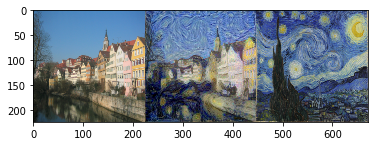

Completed


In [7]:
#################################################################################    
'''
Create a TF session and execute the graph
'''
#################################################################################    

sess = tf.Session()

'''Initialize and loading the weights'''
#Initialize the variables and load the weights for VGG
sess.run(tf.global_variables_initializer())
vgg.load_weights(FLAGS.models_path,sess)
    
    
#################################################################################    
'''
Execute the graph several times to get the desired output
'''   
#################################################################################  
feed = {content_tensor:content_image, style_tensor:style_image}
        
if FLAGS.optimizer=='BFGS':
    fetch = [total_loss, content_loss, style_loss]
    optimizer.minimize(sess,feed_dict=feed,fetches=fetch, loss_callback=callback)
    output_image = sess.run(output_tensor)
    output_image[output_image<0]=0
    plt.imshow(np.hstack([content_image[0],output_image[0],style_image[0] ])/output_image.max()); plt.show()

else:
    for i in range(FLAGS.max_steps):
        fetch = [optimizer_step, total_loss, content_loss, style_loss, output_tensor]
        # Define the session.run() with fetch and feed parameters
        _, loss, c_loss, s_loss, output_image = sess.run(fetch, feed)
        print('Iteration : %4d, total_loss : %g, content_loss : %g, style_loss : %g' % (i,loss, c_loss, s_loss))
        if i%10==0:
            plt.imshow(np.hstack([content_image[0],output_image[0],style_image[0] ])/output_image.max()); plt.show()
print('Completed')
